In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
mnist_data = np.loadtxt(open("mnist_train_small.csv"), delimiter=',')

In [3]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

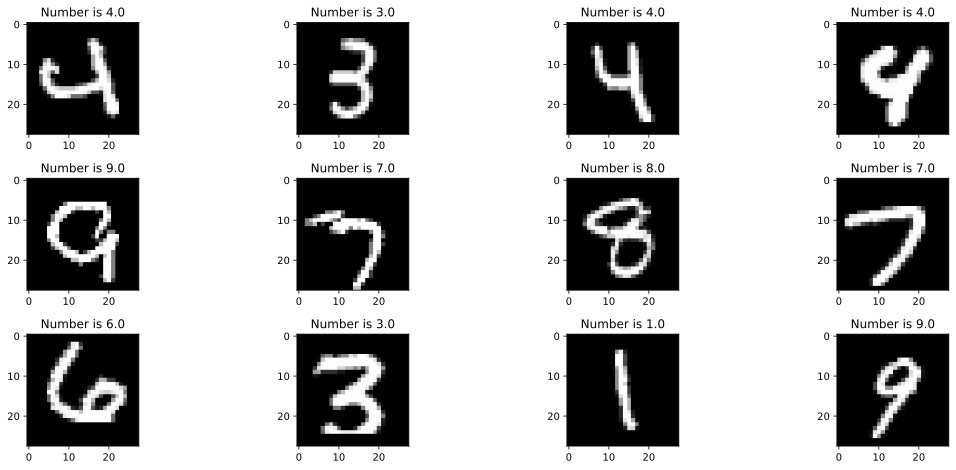

In [4]:
_, axis = plt.subplots(3, 4, figsize=(16, 7))

for ax in axis.flatten():
    random_image = np.random.randint(0, high=data.shape[0])
    
    image = np.reshape(data[random_image, :], (28, 28))
    ax.imshow(image, cmap="gray")
    
    ax.set_title(f"Number is {labels[random_image]}")
    
plt.tight_layout(rect=[0, 0, 1, 0.95])

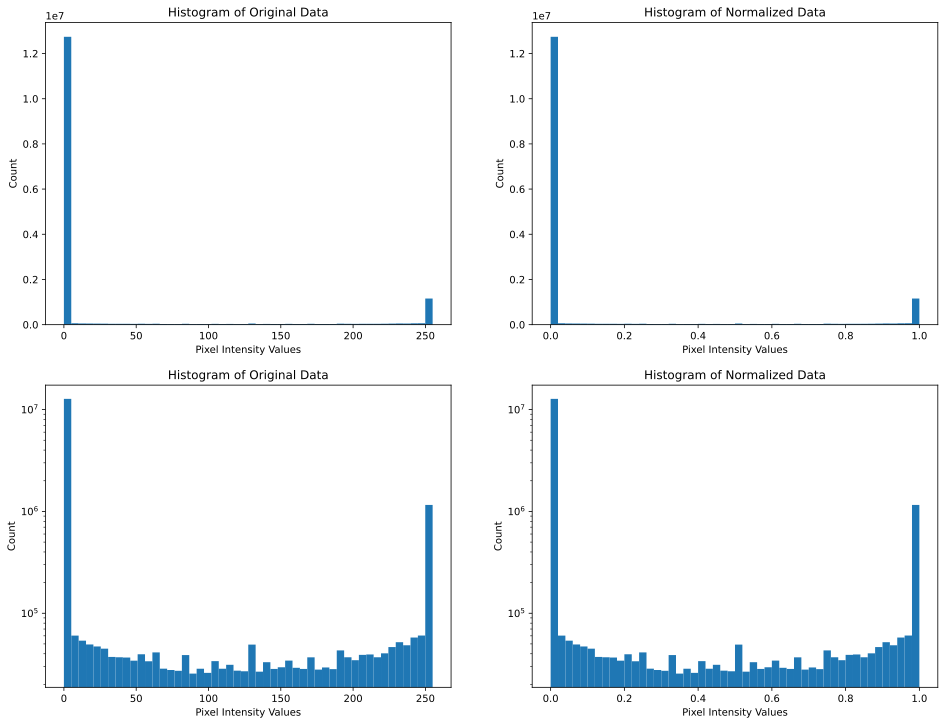

In [5]:
data_norm = data / np.max(data)

_, axis = plt.subplots(2, 2, figsize=(16, 12))

axis[0, 0].hist(data.flatten(), 50)
axis[0, 0].set_ylabel("Count")
axis[0, 0].set_xlabel("Pixel Intensity Values")
axis[0, 0].set_title("Histogram of Original Data")

axis[0, 1].hist(data_norm.flatten(), 50)
axis[0, 1].set_ylabel("Count")
axis[0, 1].set_xlabel("Pixel Intensity Values")
axis[0, 1].set_title("Histogram of Normalized Data")

axis[1, 0].hist(data.flatten(), 50)
axis[1, 0].set_ylabel("Count")
axis[1, 0].set_xlabel("Pixel Intensity Values")
axis[1, 0].set_title("Histogram of Original Data")
axis[1, 0].set_yscale("log")

axis[1, 1].hist(data_norm.flatten(), 50)
axis[1, 1].set_ylabel("Count")
axis[1, 1].set_xlabel("Pixel Intensity Values")
axis[1, 1].set_title("Histogram of Normalized Data")
axis[1, 1].set_yscale("log");

In [6]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
def annMnistModel():
    
    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 64)
            
            self.hidden_1 = nn.Linear(64, 32)
            self.hidden_2 = nn.Linear(32, 32)
            
            self.output = nn.Linear(32, 10)
        
        def forward(self, x):
            x = self.input(x)
            x = F.relu(x)
            
            x = self.hidden_1(x)
            x = F.relu(x)
            
            x = self.hidden_2(x)
            x = F.relu(x)
            
            return torch.log_softmax(self.output(x), axis=1)
    
    annMnist = AnnMnist()
    
    loss_fun = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(annMnist.parameters(), lr=0.01)
    
    return annMnist, loss_fun, optimizer

In [8]:
num_epochs = 100

def trainModel():
    
    annMnist, loss_fun, optimizer = annMnistModel()
    
    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        annMnist.train()
        
        batch_loss = []
        batch_acc = []
        
        for x, y in train_dataloader:
            y_hat = annMnist(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
        
        train_acc.append(np.mean(batch_acc))
        
        losses[epoch] = np.mean(batch_loss)
        
        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(annMnist(x), axis=1) == y).float()))
        
    return train_acc, test_acc, losses, annMnist

In [9]:
train_acc, test_acc, losses, annMnist = trainModel()

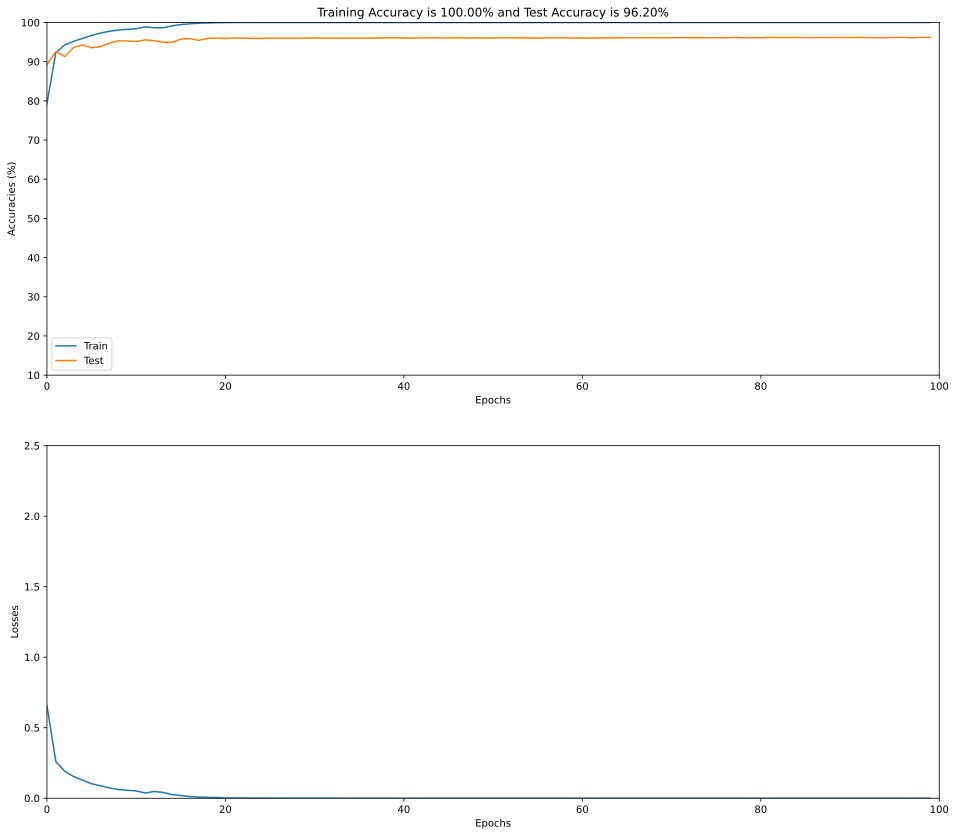

In [10]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(losses.detach())
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].set_xlim([0, 100])
axis[1].set_ylim([0, 2.5]);

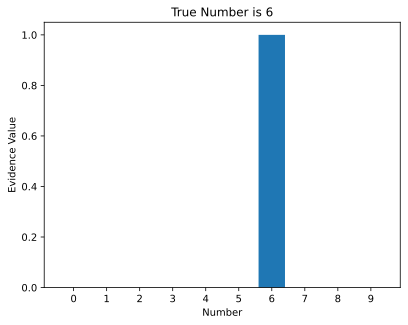

In [11]:
x, y = next(iter(test_dataloader))
predictions = annMnist(x).detach()

sample = 100

plt.bar(range(10), torch.exp(predictions[sample]))
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence Value")
plt.title(f"True Number is {y[sample].item()}");

# Binarization the Data

In [12]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]
data_norm = (data > 128).astype(int)

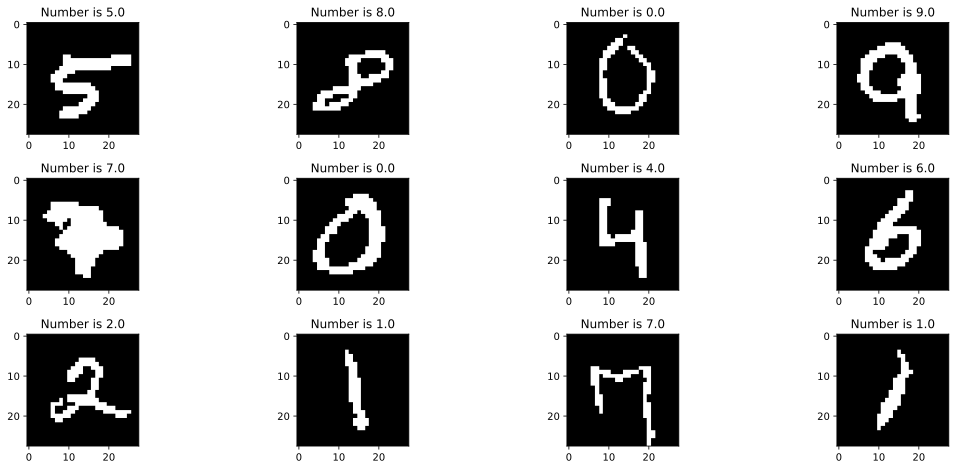

In [13]:
_, axis = plt.subplots(3, 4, figsize=(16, 7))

for ax in axis.flatten():
    random_image = np.random.randint(0, high=data_norm.shape[0])

    image = np.reshape(data_norm[random_image, :], (28, 28))
    ax.imshow(image, cmap="gray")

    ax.set_title(f"Number is {labels[random_image]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])

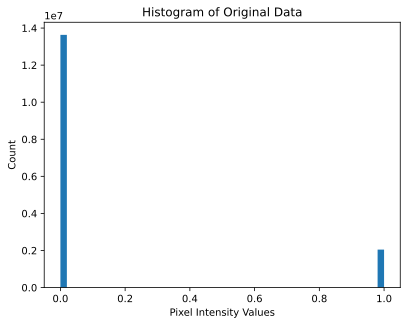

In [14]:
plt.hist(data_norm.flatten(), 50)
plt.ylabel("Count")
plt.xlabel("Pixel Intensity Values")
plt.title("Histogram of Original Data");

In [15]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [16]:
train_acc, test_acc, losses, annMnist = trainModel()

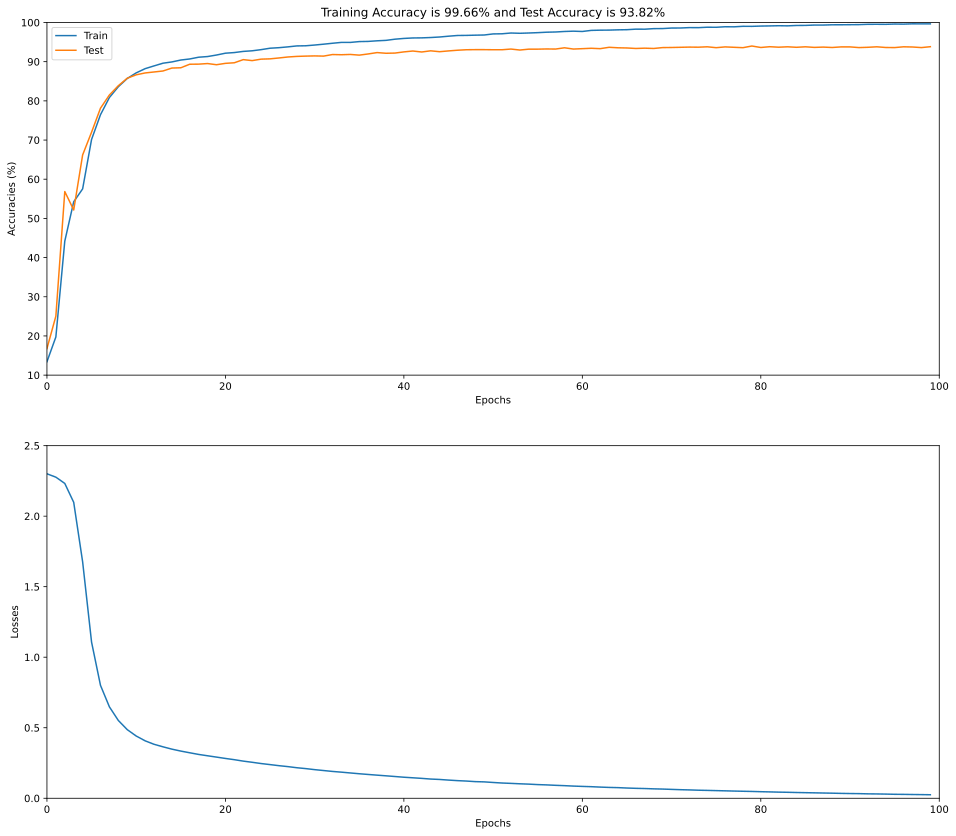

In [17]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(losses.detach())
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].set_xlim([0, 100])
axis[1].set_ylim([0, 2.5]);

# With Min-Max Scale on Train and Test

In [18]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

In [19]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data_norm = (train_data - torch.min(train_data))/(torch.max(train_data) - torch.min(train_data))
test_data_norm = (test_data - torch.min(test_data))/(torch.max(test_data) - torch.min(test_data))

train_data_norm = TensorDataset(train_data_norm, train_labels)
test_data_norm = TensorDataset(test_data_norm, test_labels)

train_dataloader = DataLoader(train_data_norm, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data_norm, batch_size=test_data_norm.tensors[0].shape[0])

In [20]:
num_epochs = 100

def trainModel():

    annMnist, loss_fun, optimizer = annMnistModel()

    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annMnist.train()

        batch_loss = []
        batch_acc = []

        for x, y in train_dataloader:
            y_hat = annMnist(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

        train_acc.append(np.mean(batch_acc))

        train_loss[epoch] = np.mean(batch_loss)

        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            y_hat = annMnist(x)

            test_loss[epoch] = loss_fun(y_hat, y)
            test_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    return train_acc, test_acc, train_loss, test_loss

In [21]:
train_acc, test_acc, train_loss, test_loss = trainModel()

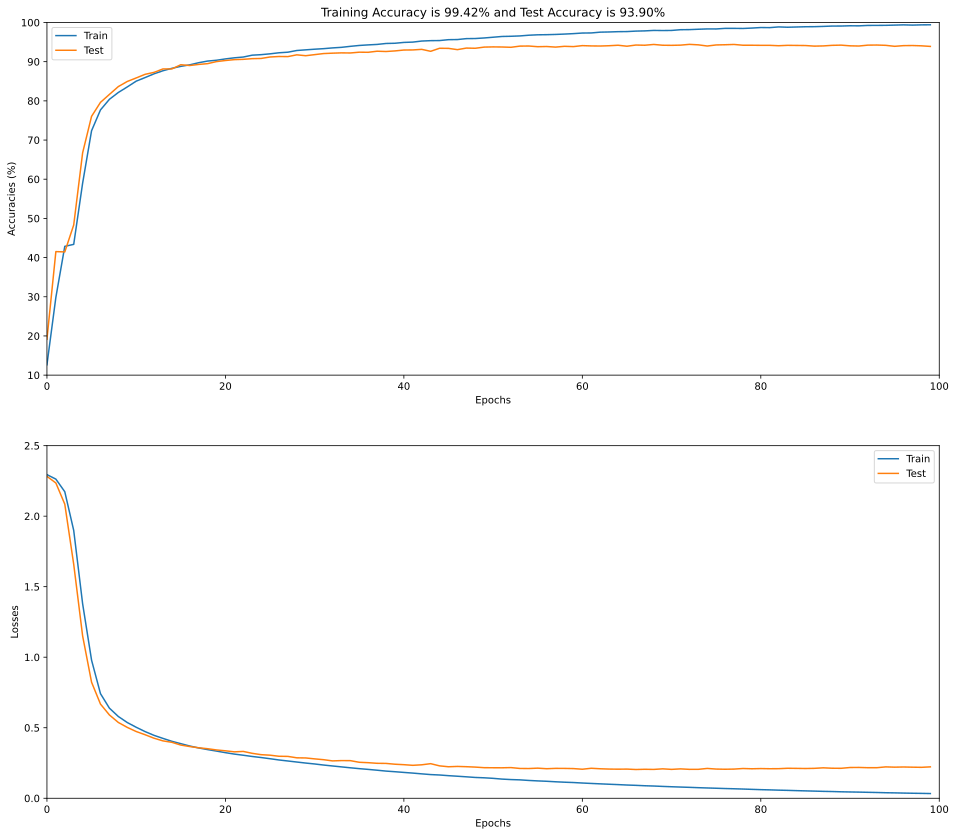

In [22]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(train_loss.detach())
axis[1].plot(test_loss.detach())
axis[1].legend(["Train", "Test"])
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].set_xlim([0, 100])
axis[1].set_ylim([0, 2.5]);

# Min-Max Normalization on Train

In [23]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

In [24]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data_norm = (train_data - torch.min(train_data))/(torch.max(train_data) - torch.min(train_data))

train_data_norm = TensorDataset(train_data_norm, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_data_norm, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [25]:
train_acc, test_acc, train_loss, test_loss = trainModel()

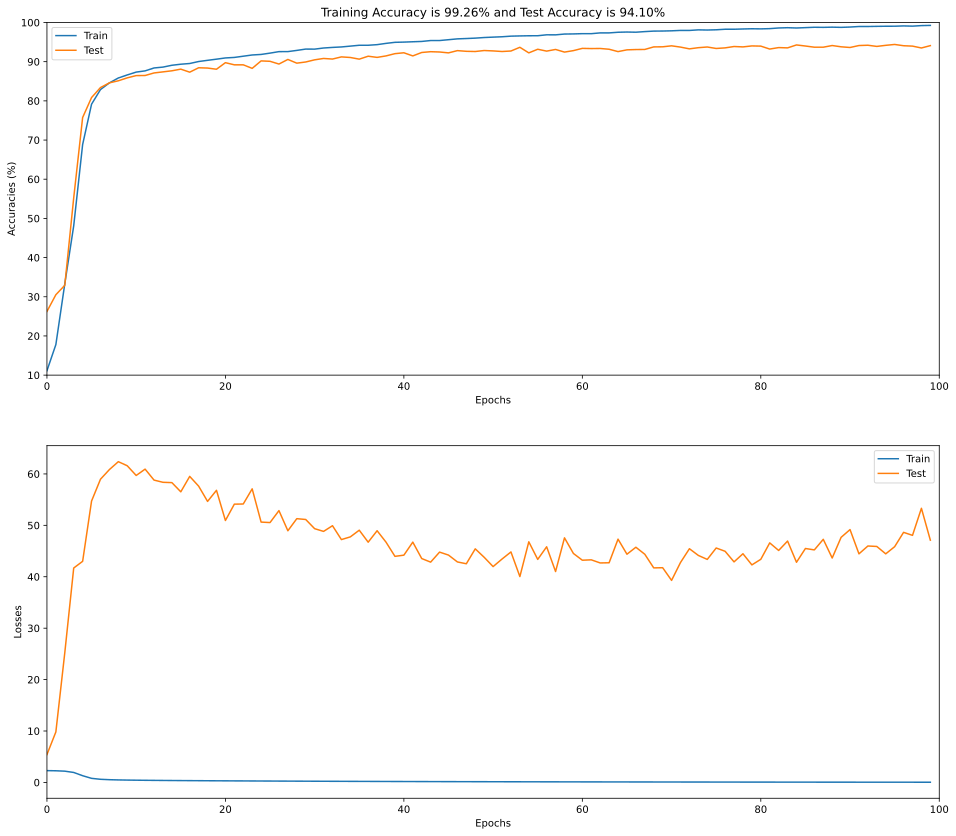

In [26]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(train_loss.detach())
axis[1].plot(test_loss.detach())
axis[1].legend(["Train", "Test"])
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].set_xlim([0, 100]);

# Min-Max Normalization on Test

In [27]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

In [28]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

test_data_norm = (test_data - torch.min(test_data))/(torch.max(test_data) - torch.min(test_data))

train_data = TensorDataset(train_data, train_labels)
test_data_norm = TensorDataset(test_data_norm, test_labels)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data_norm, batch_size=test_data_norm.tensors[0].shape[0])

In [29]:
train_acc, test_acc, train_loss, test_loss = trainModel()

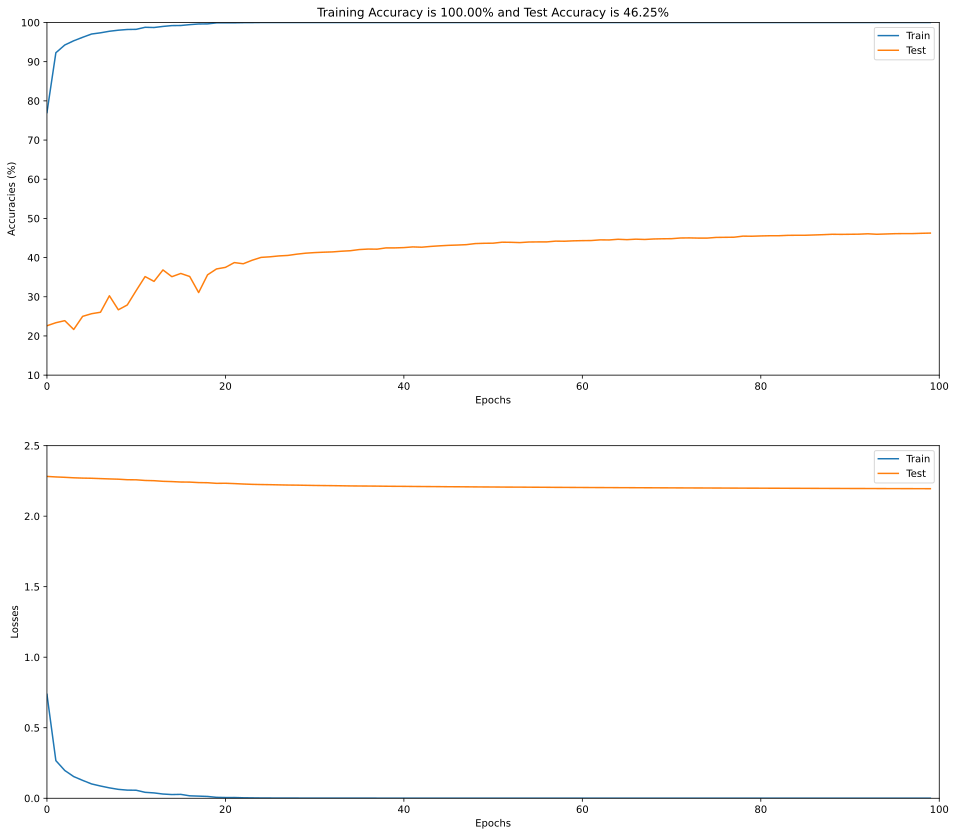

In [30]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_ylim([10, 100])
axis[0].set_xlim([0, 100])
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(train_loss.detach())
axis[1].plot(test_loss.detach())
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].legend(["Train", "Test"])
axis[1].set_xlim([0, 100])
axis[1].set_ylim([0, 2.5]);

# Grid Search on MNIST with Hidden Layers and Units

In [31]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

In [32]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data_norm = (train_data - torch.min(train_data))/(torch.max(train_data) - torch.min(train_data))
test_data_norm = (test_data - torch.min(test_data))/(torch.max(test_data) - torch.min(test_data))

train_data_norm = TensorDataset(train_data_norm, train_labels)
test_data_norm = TensorDataset(test_data_norm, test_labels)

train_dataloader = DataLoader(train_data_norm, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data_norm, batch_size=test_data_norm.tensors[0].shape[0])

In [33]:
def annMnistModel(hidden_layer, unit):

    class AnnMnist(nn.Module):
        def __init__(self, hidden_layer, units):
            super().__init__()
            
            self.layers = nn.ModuleDict()
            self.hidden_layer = hidden_layer
            
            self.layers["input"] = nn.Linear(784, units)
            
            for i in range(self.hidden_layer):
                self.layers[f"hidden_{i}"] = nn.Linear(units, units)
            
            self.layers["output"] = nn.Linear(units, 10)

        def forward(self, x):
            x = self.layers["input"](x)
            x = F.relu(x)
            
            for i in range(self.hidden_layer):
                x = self.layers[f"hidden_{i}"](x)
                x = F.relu(x)

            return torch.log_softmax(self.layers["output"](x), axis=1)

    annMnist = AnnMnist(hidden_layer, unit)

    loss_fun = nn.NLLLoss()

    optimizer = torch.optim.SGD(annMnist.parameters(), lr=0.01)

    return annMnist, loss_fun, optimizer

In [34]:
num_epochs = 100

def trainModel(hidden_layer, unit):

    annMnist, loss_fun, optimizer = annMnistModel(hidden_layer, unit)

    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annMnist.train()

        batch_acc = []

        for x, y in train_dataloader:
            y_hat = annMnist(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

        train_acc.append(np.mean(batch_acc))

        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(annMnist(x), axis=1) == y).float()))

    return train_acc, test_acc

In [35]:
import time

hidden_layers = [1, 2, 3]
units = np.arange(50, 251, 50)

trainAcc = np.zeros((len(units), len(hidden_layers)))
testAcc = np.zeros((len(units), len(hidden_layers)))

for i, unit in enumerate(units):
    for j, hidden_layer in enumerate(hidden_layers):
        start = time.time()
        train_acc, test_acc = trainModel(hidden_layer, unit)
        end = time.time()
        trainAcc[i, j] = np.mean(train_acc[-10:])
        testAcc[i, j] = np.mean(test_acc[-10:])
        print(f"{hidden_layer} hidden layer and {unit} units take {end-start:0.2f} seconds with train: {train_acc[-1]:0.2f}% and test: {test_acc[-1]:0.2f}%.")

1 hidden layer and 50 units take 66.10 seconds with train: 97.64% and test: 95.07%.
2 hidden layer and 50 units take 72.51 seconds with train: 98.82% and test: 95.12%.
3 hidden layer and 50 units take 79.73 seconds with train: 99.51% and test: 94.00%.
1 hidden layer and 100 units take 73.38 seconds with train: 98.27% and test: 95.30%.
2 hidden layer and 100 units take 81.63 seconds with train: 99.36% and test: 95.85%.
3 hidden layer and 100 units take 91.33 seconds with train: 99.93% and test: 95.85%.
1 hidden layer and 150 units take 79.90 seconds with train: 98.33% and test: 95.82%.
2 hidden layer and 150 units take 91.90 seconds with train: 99.44% and test: 95.88%.
3 hidden layer and 150 units take 103.36 seconds with train: 99.93% and test: 95.57%.
1 hidden layer and 200 units take 85.76 seconds with train: 98.39% and test: 95.92%.
2 hidden layer and 200 units take 100.05 seconds with train: 99.49% and test: 96.10%.
3 hidden layer and 200 units take 113.78 seconds with train: 99.95

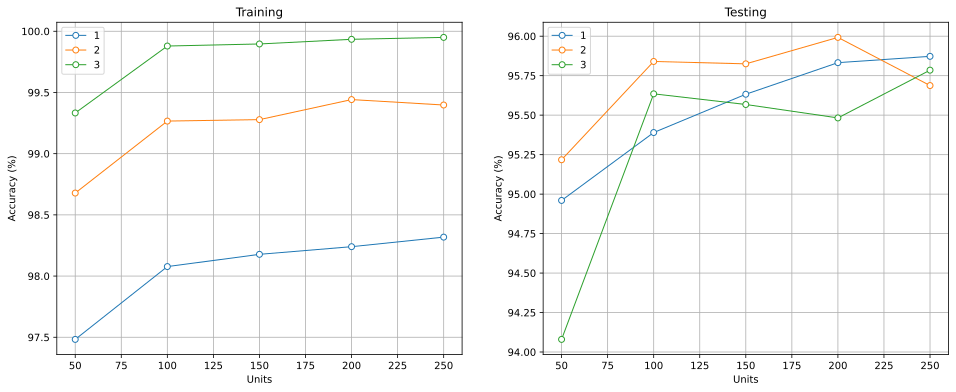

In [36]:
_, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].plot(units, trainAcc, 'o-', markerfacecolor='w', linewidth=1)
axis[1].plot(units, testAcc, 'o-', markerfacecolor='w', linewidth=1)

for i in range(2):
    axis[i].legend(hidden_layers)
    axis[i].set_xlabel("Units")
    axis[i].set_ylabel("Accuracy (%)")
    axis[i].set_title(["Training" if i==0 else "Testing"][0])
    axis[i].grid()

# Grid Search on MNIST with Optimizers and Learning Rate

In [37]:
def annMnistModel(optim, lr):

    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 150)
            
            self.hidden_1 = nn.Linear(150, 150)
            self.hidden_2 = nn.Linear(150, 150)
            self.hidden_3 = nn.Linear(150, 150)

            self.output = nn.Linear(150, 10)

        def forward(self, x):
            x = self.input(x)
            x = F.relu(x)

            x = self.hidden_1(x)
            x = F.relu(x)

            x = self.hidden_2(x)
            x = F.relu(x)

            x = self.hidden_3(x)
            x = F.relu(x)

            return self.output(x)

    annMnist = AnnMnist()

    loss_fun = nn.CrossEntropyLoss()
    
    opti_fun = getattr(torch.optim, optim)
    optimizer = opti_fun(annMnist.parameters(), lr=lr)

    return annMnist, loss_fun, optimizer

In [38]:
num_epochs = 100

def trainModel(optim, lr):

    annMnist, loss_fun, optimizer = annMnistModel(optim, lr)

    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annMnist.train()

        batch_acc = []

        for x, y in train_dataloader:
            y_hat = annMnist(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

        train_acc.append(np.mean(batch_acc))

        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            test_acc.append(100*torch.mean((torch.argmax(annMnist(x), axis=1) == y).float()))

    return train_acc, test_acc

In [39]:
optimizers = ["SGD", "RMSprop", "Adam"]
learning_rates = np.logspace(np.log10(0.0001), np.log10(0.1), 6)

trainAcc = np.zeros((len(learning_rates), len(optimizers)))
testAcc = np.zeros((len(learning_rates), len(optimizers)))

for i, learning_rate in enumerate(learning_rates):
    for j, optimizer in enumerate(optimizers):
        start = time.time()
        train_acc, test_acc = trainModel(optimizer, learning_rate)
        end = time.time()
        trainAcc[i, j] = np.mean(train_acc[-10:])
        testAcc[i, j] = np.mean(test_acc[-10:])
        print(f"{optimizer} optimizer and {learning_rate:0.4f} learning rate take {end-start:0.2f} seconds with train: {train_acc[-1]:0.2f}% and test: {test_acc[-1]:0.2f}%.")

SGD optimizer and 0.0001 learning rate take 104.82 seconds with train: 18.67% and test: 19.58%.
RMSprop optimizer and 0.0001 learning rate take 138.01 seconds with train: 99.99% and test: 95.32%.
Adam optimizer and 0.0001 learning rate take 166.93 seconds with train: 100.00% and test: 95.65%.
SGD optimizer and 0.0004 learning rate take 104.47 seconds with train: 18.61% and test: 19.45%.
RMSprop optimizer and 0.0004 learning rate take 146.75 seconds with train: 100.00% and test: 97.00%.
Adam optimizer and 0.0004 learning rate take 174.39 seconds with train: 100.00% and test: 96.22%.
SGD optimizer and 0.0016 learning rate take 103.09 seconds with train: 88.92% and test: 87.45%.
RMSprop optimizer and 0.0016 learning rate take 177.01 seconds with train: 100.00% and test: 97.28%.
Adam optimizer and 0.0016 learning rate take 193.43 seconds with train: 100.00% and test: 97.22%.
SGD optimizer and 0.0063 learning rate take 102.41 seconds with train: 98.86% and test: 94.85%.
RMSprop optimizer an

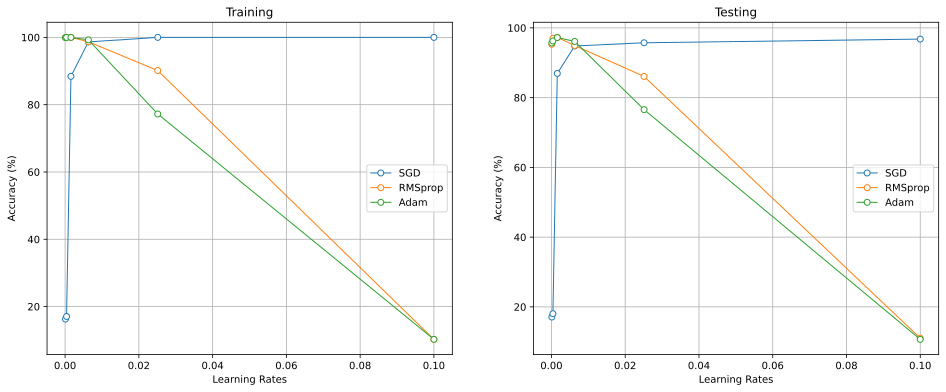

In [40]:
_, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].plot(learning_rates, trainAcc, 'o-', markerfacecolor='w', linewidth=1)
axis[1].plot(learning_rates, testAcc, 'o-', markerfacecolor='w', linewidth=1)

for i in range(2):
    axis[i].legend(optimizers)
    axis[i].set_xlabel("Learning Rates")
    axis[i].set_ylabel("Accuracy (%)")
    axis[i].set_title(["Training" if i==0 else "Testing"][0])
    axis[i].grid()

# Test the data from Untrained Number

In [59]:
labels = mnist_data[:, 0]
data = mnist_data[:, 1:]

In [60]:
labels_without_one = []
labels_with_one = []
data_without_one = []
data_with_one = []

for i in range(len(labels)):
    if labels[i] != 1:
        labels_without_one.append(labels[i])
        data_without_one.append(data[i])
    else:
        labels_with_one.append(labels[i])
        data_with_one.append(data[i])

labels_without_one = np.array(labels_without_one)
labels_with_one = np.array(labels_with_one)
data_without_one = np.array(data_without_one)
data_with_one = np.array(data_with_one)

In [61]:
labels_without_one = torch.tensor(labels_without_one).long()
labels_with_one = torch.tensor(labels_with_one).long()
data_without_one = torch.tensor(data_without_one).float()
data_with_one = torch.tensor(data_with_one).float()

data_without_one = (data_without_one - torch.min(data_without_one))/(torch.max(data_without_one) - torch.min(data_without_one))
data_with_one = (data_with_one - torch.min(data_with_one))/(torch.max(data_with_one) - torch.min(data_with_one))

train_data_norm = TensorDataset(data_without_one, labels_without_one)
test_data_norm = TensorDataset(data_with_one, labels_with_one)

train_dataloader = DataLoader(train_data_norm, shuffle=True, batch_size=64, drop_last=True)
test_dataloader = DataLoader(test_data_norm, batch_size=test_data_norm.tensors[0].shape[0])

In [67]:
def annMnistModel():

    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 150)

            self.hidden_1 = nn.Linear(150, 150)
            self.hidden_2 = nn.Linear(150, 150)
            self.hidden_3 = nn.Linear(150, 150)

            self.output = nn.Linear(150, 10)

        def forward(self, x):
            x = self.input(x)
            x = F.relu(x)

            x = self.hidden_1(x)
            x = F.relu(x)

            x = self.hidden_2(x)
            x = F.relu(x)

            x = self.hidden_3(x)
            x = F.relu(x)

            return torch.log_softmax(self.output(x), axis=1)

    annMnist = AnnMnist()

    loss_fun = nn.NLLLoss()

    optimizer = torch.optim.SGD(annMnist.parameters(), lr=0.1)

    return annMnist, loss_fun, optimizer

In [68]:
num_epochs = 100

def trainModel():

    annMnist, loss_fun, optimizer = annMnistModel()

    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annMnist.train()

        batch_loss = []
        batch_acc = []

        for x, y in train_dataloader:
            y_hat = annMnist(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

            batch_loss.append(loss.item())

        train_acc.append(np.mean(batch_acc))
        train_loss[epoch] = np.mean(batch_loss)

        annMnist.eval()
        x, y = next(iter(test_dataloader))
        with torch.no_grad():
            y_hat = annMnist(x)

            test_loss[epoch] = loss_fun(y_hat, y)
            test_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    return train_acc, test_acc, train_loss, test_loss

In [69]:
train_acc, test_acc, train_loss, test_loss = trainModel()

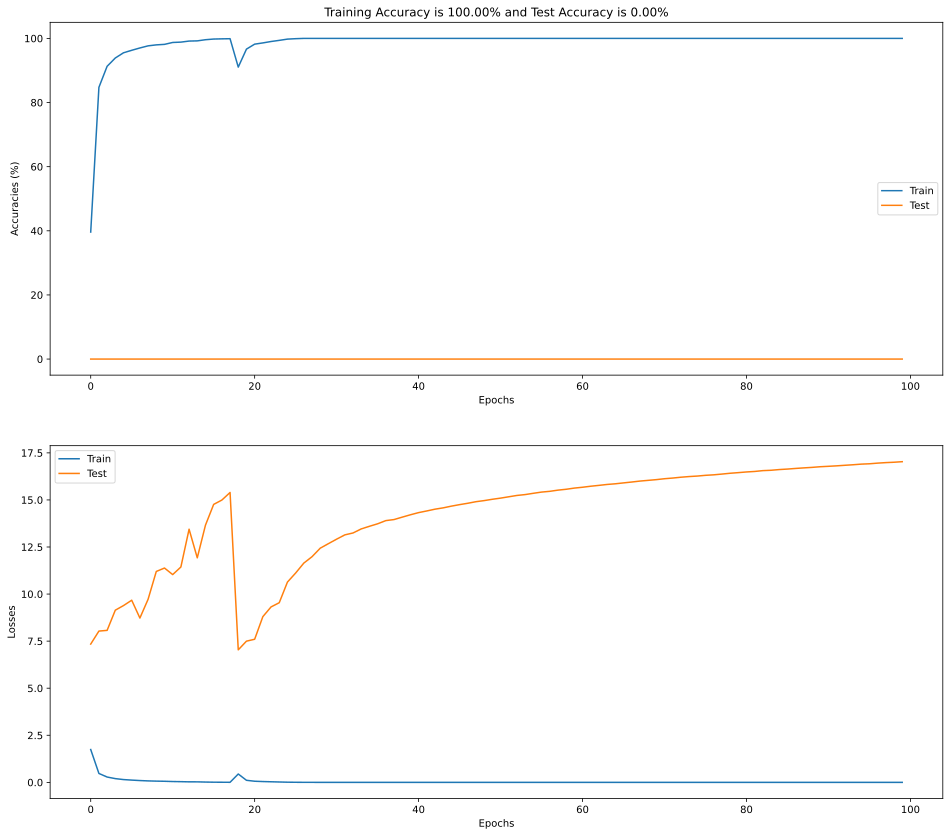

In [70]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))

axis[0].plot(train_acc)
axis[0].plot(test_acc)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].legend(["Train", "Test"])
axis[0].set_title(f"Training Accuracy is {train_acc[-1]:0.2f}% and Test Accuracy is {test_acc[-1]:0.2f}%")

axis[1].plot(train_loss.detach())
axis[1].plot(test_loss.detach())
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].legend(["Train", "Test"]);